In [1]:
import kagglehub
import torch
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tqdm as tq
import timm
import numpy as np
from torch.utils.data import Subset
from sam import SAM


/home/hhabib/.pyenv/versions/AIML/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PACS_base_path = kagglehub.dataset_download("nickfratto/pacs-dataset")

In [3]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
pacs_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

pacs_sketch_dataset = datasets.ImageFolder(root=f"{PACS_base_path}/pacs_data/pacs_data/sketch", transform=pacs_transforms)
pacs_photo_dataset = datasets.ImageFolder(root=f"{PACS_base_path}/pacs_data/pacs_data/photo", transform=pacs_transforms)
pacs_cartoon_dataset = datasets.ImageFolder(root=f"{PACS_base_path}/pacs_data/pacs_data/cartoon", transform=pacs_transforms)
pacs_art_dataset = datasets.ImageFolder(root=f"{PACS_base_path}/pacs_data/pacs_data/art_painting", transform=pacs_transforms)   

In [5]:

pacs_photo_test = Subset(pacs_photo_dataset, range(50))
pacs_art_test = Subset(pacs_art_dataset, range(50))
pacs_cartoon_test = Subset(pacs_cartoon_dataset, range(50))

pacs_art_train = Subset(pacs_art_dataset, range(50, len(pacs_art_dataset)))
pacs_photo_train = Subset(pacs_photo_dataset, range(50, len(pacs_photo_dataset)))
pacs_cartoon_train = Subset(pacs_cartoon_dataset, range(50, len(pacs_cartoon_dataset)))

source_test_dataset = ConcatDataset([pacs_photo_test, pacs_art_test, pacs_cartoon_test])


train_dataset = ConcatDataset([pacs_art_train, pacs_photo_train, pacs_cartoon_train])


source_test_loader = DataLoader(source_test_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
target_loader = DataLoader(pacs_sketch_dataset, batch_size=32, shuffle=True)

In [6]:
type(train_dataset)

torch.utils.data.dataset.ConcatDataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.405462..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9131652..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


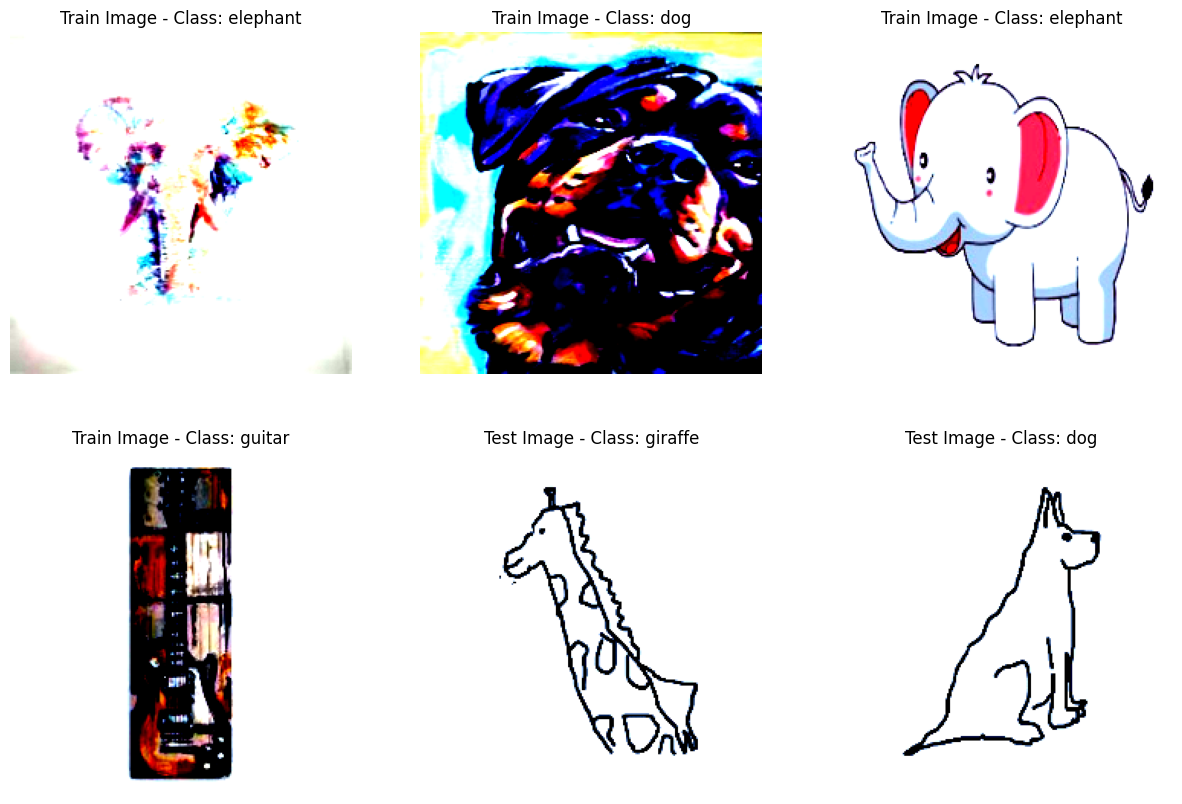

In [7]:
classes = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]


len_train = len(train_loader.dataset)
len_test = len(target_loader.dataset)

random_train_indices = np.random.choice(np.arange(len_train), size=4, replace=False)

random_test_indices = np.random.choice(np.arange(len_test), size=2, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, idx in enumerate(random_train_indices):
    image, label = train_loader.dataset[idx]
    ax = axes[i // 3, i % 3]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f"Train Image - Class: {classes[label]}")
    ax.axis('off')

for i, idx in enumerate(random_test_indices):
    image, label = target_loader.dataset[idx]
    ax = axes[(i + 4) // 3, (i + 4) % 3]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f"Test Image - Class: {classes[label]}")
    ax.axis('off')


In [8]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_classes = 7
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes, bias=True)

In [ ]:
base_optimizer = optim.Adam
optimizer = SAM(model.parameters(), base_optimizer, rho=0.05, adaptive=False)
criterion = nn.CrossEntropyLoss()
model = model.to(device)

#### Base line accuracy on source domains

In [12]:
losses = []
accuracies = []
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for x, y in tq.tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.first_step()
        running_loss += loss.item()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.second_step()
        _, predicted = torch.max(logits.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

100%|██████████| 185/185 [03:40<00:00,  1.19s/it]


Epoch 1/15, Loss: 1.2170, Accuracy: 45.53%


100%|██████████| 185/185 [02:54<00:00,  1.06it/s]


Epoch 2/15, Loss: 0.5049, Accuracy: 76.15%


100%|██████████| 185/185 [02:54<00:00,  1.06it/s]


Epoch 3/15, Loss: 0.3044, Accuracy: 82.29%


100%|██████████| 185/185 [02:54<00:00,  1.06it/s]


Epoch 4/15, Loss: 0.2207, Accuracy: 86.30%


100%|██████████| 185/185 [02:54<00:00,  1.06it/s]


Epoch 5/15, Loss: 0.1799, Accuracy: 87.64%


100%|██████████| 185/185 [02:54<00:00,  1.06it/s]


Epoch 6/15, Loss: 0.1468, Accuracy: 89.04%


100%|██████████| 185/185 [02:54<00:00,  1.06it/s]


Epoch 7/15, Loss: 0.1184, Accuracy: 90.43%


100%|██████████| 185/185 [02:54<00:00,  1.06it/s]


Epoch 8/15, Loss: 0.1021, Accuracy: 90.75%


100%|██████████| 185/185 [02:54<00:00,  1.06it/s]


Epoch 9/15, Loss: 0.0831, Accuracy: 92.03%


100%|██████████| 185/185 [02:54<00:00,  1.06it/s]


Epoch 10/15, Loss: 0.0731, Accuracy: 92.59%


100%|██████████| 185/185 [02:54<00:00,  1.06it/s]


Epoch 11/15, Loss: 0.0638, Accuracy: 92.74%


100%|██████████| 185/185 [02:54<00:00,  1.06it/s]


Epoch 12/15, Loss: 0.0555, Accuracy: 93.45%


100%|██████████| 185/185 [02:54<00:00,  1.06it/s]


Epoch 13/15, Loss: 0.0495, Accuracy: 93.40%


100%|██████████| 185/185 [02:54<00:00,  1.06it/s]


Epoch 14/15, Loss: 0.0426, Accuracy: 93.91%


100%|██████████| 185/185 [02:54<00:00,  1.06it/s]

Epoch 15/15, Loss: 0.0401, Accuracy: 93.89%


#### Baseline accuracy on source domain

In [10]:
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for x, y in tq.tqdm(source_test_loader):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, predicted = torch.max(logits.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 5/5 [00:01<00:00,  4.68it/s]

Test Accuracy: 98.67%


In [11]:
correct = 0
total = 0

with torch.no_grad():
    for x, y in tq.tqdm(target_loader):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, predicted = torch.max(logits.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 123/123 [00:23<00:00,  5.14it/s]

Test Accuracy: 72.05%


In [9]:
model = torch.load("sam_resnet_72_t.pth", weights_only=False)

In [12]:
cartoon_test_loader = DataLoader(pacs_cartoon_test, batch_size=32, shuffle=True)
art_test_loader = DataLoader(pacs_art_test, batch_size=32, shuffle=True)
photo_test_loader = DataLoader(pacs_photo_test, batch_size=32, shuffle=True)

In [13]:
correct = 0
total = 0

with torch.no_grad():
    for x, y in tq.tqdm(cartoon_test_loader):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, predicted = torch.max(logits.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

Test Accuracy: 100.00%


In [14]:
correct = 0
total = 0

with torch.no_grad():
    for x, y in tq.tqdm(art_test_loader):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, predicted = torch.max(logits.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

Test Accuracy: 98.00%


In [15]:
correct = 0
total = 0

with torch.no_grad():
    for x, y in tq.tqdm(photo_test_loader):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        _, predicted = torch.max(logits.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 2/2 [00:00<00:00,  6.58it/s]

Test Accuracy: 98.00%


Text(0, 0.5, 'Accuracy (%)')

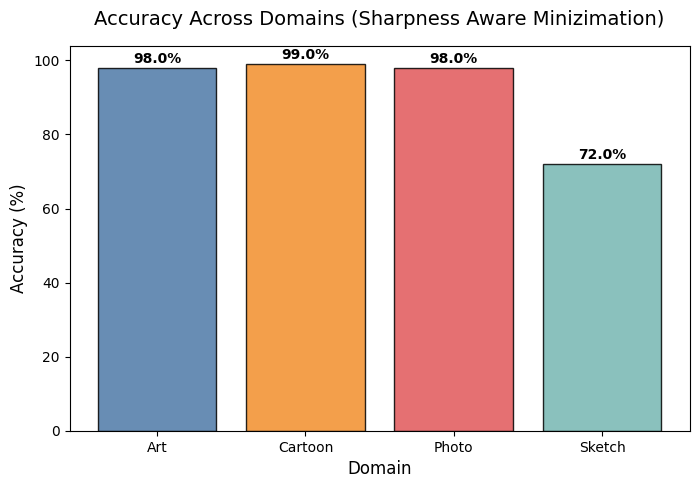

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# === Editable arrays ===
domains = ["Art", "Cartoon", "Photo", "Sketch"]  # labels for the bars
accuracies = [98.0, 99.0, 98.0, 72.05]            # accuracy values
colors = ["#4E79A7", "#F28E2B", "#E15759", "#76B7B2"]  # bar colors

# === Basic bar plot ===
plt.figure(figsize=(8, 5))
bars = plt.bar(domains, accuracies, color=colors, edgecolor="black", alpha=0.85)

# Add value labels above bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f"{acc:.1f}%", ha="center", va="bottom", fontsize=10, fontweight="bold")

# === Customization ===
plt.title("Accuracy Across Domains (Sharpness Aware Minizimation)", fontsize=14, pad=15)
plt.xlabel("Domain", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
